# **Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Import relevant packages**

In [1]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [2]:
load_dotenv()

False

### **2. Setup your openai key**

In [3]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

In [4]:
import openai
import pandas as pd
from pandas import json_normalize

# Verify installed OpenAI models
models_response = openai.models.list()

# Extract the data
models_data = models_response.data  # Access the 'data' attribute directly

# Normalize the data if necessary
df = pd.json_normalize([model.to_dict() for model in models_data])

# Convert 'created' Unix timestamps to datetime
if 'created' in df.columns:
    df['created'] = pd.to_datetime(df['created'], unit='s')

# Display the DataFrame
display(df)


,id,created,object,owned_by
0,gpt-4o,2024-05-10 18:50:49,model,system
1,gpt-3.5-turbo-instruct,2023-08-24 18:23:47,model,system
2,text-embedding-3-small,2024-01-22 18:43:17,model,system
3,gpt-3.5-turbo-0125,2024-01-23 22:19:18,model,system
4,text-embedding-ada-002,2022-12-16 19:01:39,model,openai-internal


### **3.  Retrieve the documents / dataset to be used**

In [5]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


### **4. Process dataset as langchain document for further processing**

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. Test Evaluation Dataset Generation using Ragas**

In [7]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
critic_llm = ChatOpenAI(model="gpt-4o")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_instruct = ChatOpenAI(model="gpt-3.5-turbo-instruct")

In [8]:
generator = TestsetGenerator.from_langchain(generator_llm , critic_llm , embeddings)

In [9]:
# generate testset - generate_with_langchain_docs failing with errors about 80% of the time
# is this a langchain version issue or something else?
# should raise_exceptions and with_debugging_logs be set to False as recommended in the article below?  what is the impact of doing so?
# Ragas Docs:  https://docs.ragas.io/en/stable/howtos/customisations/azure-openai.html#test-set-generation

testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10, 
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

embedding nodes:   0%|          | 0/36 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

### **5a. Evaluation dataset to Pandas for better visualization**

In [10]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How can audio embeddings be used to develop a ...,[---\n\ntitle: Examples\n\nweight: 25\n\n# If ...,Use Qdrant to develop a music recommendation e...,simple,[{'source': 'documentation/examples.md'}],True
1,What is the purpose of the Qdrant Startup Sear...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The purpose of the Qdrant Startup Search demo ...,simple,[{'source': 'demo/demo-1.md'}],True
2,What is the Qdrant vector search engine used f...,[---\n\npage_title: Vector Search Demos and Ex...,The Qdrant vector search engine is used in the...,simple,[{'source': 'demo/_index.md'}],True
3,How is a SentenceTransformer model used in the...,[---\n\ndraft: false\n\ntitle: Startup Search\...,A SentenceTransformer model is used in the Qdr...,simple,[{'source': 'demo/demo-1.md'}],True
4,What determines the order of sections in a lis...,[---\n\n#Delimiter files are used to separate ...,The weight assigned to each section determines...,simple,[{'source': 'documentation/0-dl.md'}],True
5,How does Qdrant help in semantic search in Sta...,[---\n\ndraft: false\n\ntitle: Startup Search\...,Qdrant helps in semantic search in the Startup...,reasoning,[{'source': 'demo/demo-1.md'}],True
6,How is the multi-language model in the e-comme...,[---\n\ndraft: false\n\ntitle: E-commerce prod...,The multi-language model in the e-commerce pro...,reasoning,[{'source': 'demo/demo-3.md'}],True
7,How are client libraries used for vector searc...,[;\n\n\n\nvar operationInfo = await client.Ups...,Client libraries are used for vector search in...,multi_context,[{'source': 'documentation/quick-start.md'}],True
8,"Which city is associated with ""NY""?","[: ""city""\n\n value {\n\n string_value: ""B...",nan,multi_context,"[{'source': 'documentation/quick-start.md'}, {...",True
9,What feature in the Food Discovery Demo sugges...,[---\n\ndraft: false\n\ntitle: Food Discovery\...,The Food Discovery Demo recommends more simila...,multi_context,[{'source': 'demo/demo-2.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [11]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [12]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

### **7. Setting up Qdrant**

Set up the qdrant client and then create a collection so that our documents can be stored.

In [13]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [14]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-ragas"

In [15]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='rag_collection'), CollectionDescription(name='iphone_speech'), CollectionDescription(name='finetuning'), CollectionDescription(name='jobs_iphone_2007 - take 2'), CollectionDescription(name='jobs_iphone_2007'), CollectionDescription(name='airbnb_pdf_rec_1000_200_images'), CollectionDescription(name='airbnb_pdf_rec_1000_200'), CollectionDescription(name='iphone_speech2'), CollectionDescription(name='qdrant-docs-ragas'), CollectionDescription(name='vlm_peft'), CollectionDescription(name='rag_evaluation'), CollectionDescription(name='PMarca Blogs - TE3 - MQR - 4o')])

In [16]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

2024-06-24 19:46:37.386 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


,model,dim,description,size_in_GB,sources,model_file,additional_files
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'},model.onnx,NaN
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'},model_optimized.onnx,NaN
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...,model.onnx,NaN
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...,model_optimized.onnx,NaN
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'},onnx/model.onnx,NaN
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'},onnx/model.onnx,NaN


In [17]:
##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
#embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

embedding_model.model_name

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'sentence-transformers/all-MiniLM-L6-v2'

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [18]:
docs_contents = []
docs_metadatas = []

for doc in docs_processed:
    if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
        docs_contents.append(doc.page_content)
        docs_metadatas.append(doc.metadata)
    else:
        # Handle the case where attributes are missing
        print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

print("content : ",len(docs_contents))
print("metadata : ",len(docs_metadatas))

content :  4431
metadata :  4431


### **9. Adding document chunks into Qdrant Collection**

In [19]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

['27bb10f40bd8422eb73634127f660009',
 '57681dc589fb443196f12af6f385878f',
 '1c553e02649044e189593fcfdf948ac1',
 '59d5d0841c5b471c9ebc5c279c2d3c39',
 '0093b50913c24371b4277cec3a0a84cd',
 'f19d75d12d7f49329e17536a7ec97431',
 'a04c1c244d904a4bb00af21d46f1c9db',
 'a5ea2d17dc3f498a9c4a5932721febb4',
 '1e6cc82cfb8548f98200fd873bcf0635',
 '28b2a3fbe1564914891317b864112845',
 '2171bdfdd52a4685a7c86856510930fa',
 '27646d2aa6914eca80c2c2df00e45a0e',
 '6ef83f44d7134ba097cc593316f913fa',
 'f22c750db3ab4f0db08e7bd4e8bef3b6',
 '538986ac9c924d898a0b9bbdb5ab6a80',
 '0c96939abc1d4f929586a39275ef514b',
 '074cc2ab3523414bbbfd3e8209800984',
 '3d89b4dd84414556966cfac0bd310ee5',
 '6d27d5a933454c519cac06010cb068a4',
 '63aea72f820f40b48f4c427ac68c6e42',
 'a6619424854a4c29924c055be2d161f4',
 '8a62cf3cf29b469d9388c41e48892378',
 '6982e99dae97499cb09486fd067c5dc4',
 '5d2d15bd0b0d452cb0fabb1ddaeb14fe',
 '77d8f1c556804249a212ecfc77fe3614',
 '83659f990dac4e47b21e3d0f4ff65204',
 'bb3b65b85b3d4486bec767996eba6eff',
 

In [20]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=8862)

### **10. Searching for the document**

In [21]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

Id:  1d56c58d-f476-4398-ba91-e0d596611456
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md
Id:  2ad84bdf-c074-478d-80ac-101289ff4f13
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md


### **11. Inititalize OpenAI**

In [22]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [26]:
def query_without_context(query):

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n """
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [27]:
print (query_without_context(query = "what is binary quantization?"))

 Binary quantization is a process of converting numerical data into binary form, where each value is represented by a sequence of 0s and 1s. This technique is commonly used in machine learning and data compression to reduce the size of data while preserving its essential information. You can learn more about binary quantization and its applications on page 12 of the "Data Compression" section in the documentation.


In [28]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the documentation on page 5 of the 'Benchmarking' section. This section provides detailed instructions on how to set up and run the benchmark, as well as how to interpret the results. Additionally, you can refer to the 'Benchmarking' section for more information on the benchmarking process and its importance in evaluating vector databases.


### **13. Querying with Context from Qdrant**

In [29]:
def query_with_context(query,limit):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=limit)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [30]:
question1 = "what is quantization?"
RETRIEVAL_WINDOW_SIZE_5 = 5
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response1)

 Quantization is a process that converts traditional float32 vectors into qbit vectors, leveraging the power of quantum computing to speed up the search process in ANNs. This is explained in detail in the article "Quantum Quantization and Entanglement" (source: articles/quantum-quantization.md). By creating quantum entanglement between the qbits, we can take advantage of the unique phenomenon in which the states of two or more particles become interdependent, regardless of the distance between them. This allows for highly efficient vector search algorithms to be created.


In [31]:
RETRIEVAL_WINDOW_SIZE_3 = 3
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2)

 Quantization is a fundamental concept in quantum mechanics that describes the process of discretizing continuous physical quantities into discrete values. This is necessary in order to accurately describe the behavior of particles at the quantum level. You can learn more about quantization and its importance in quantum mechanics in the article "Quantum Quantization and Entanglement" by Andrey Vasnetsov, found in the blog section of our website.


In [32]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github at https://github.com/qdrant/vector-db-benchmark. The README.md file on the repository provides detailed instructions on how to run the benchmark for a specific engine. This information can be found in the 'How to reproduce the benchmark?' section of the document 'The Emergence and Relevance of Vector Databases' in the 'benchmarks/benchmark-faq.md' file.


In [33]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. This information can be found in the document "The Emergence and Relevance of Vector Databases" under the source "benchmarks/benchmark-faq.md". Additionally, if you believe you can improve the benchmark, you can contribute to the open-source project on Github.


### **14. Prepare the evaluation dataset to evaluate our RAG system**

In [34]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data

In [35]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_3 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)

rag_eval_dataset_512_3

{'question': ['What is vaccum optimizer ?',
  'Tell me about ‘always_ram’ parameter?',
  'What is difference between scalar and product quantization?',
  'What is ‘best_score’ strategy?',
  'How does oversampling helps?',
  'What is the purpose of ‘CreatePayloadIndexAsync’?',
  'What is the purpose of ef_construct in HNSW ?',
  'How do you use ‘ordering’ parameter?',
  'What is significance of ‘on_disk_payload’ setting?',
  'What is the impact of ‘write_consistency_factor’ ?'],
 'answer': [' The vacuum optimizer is a feature that helps to optimize the performance of a database by removing unnecessary data and reorganizing the remaining data. This can improve the speed and efficiency of database operations. This feature is available in the OptimizersConfigDiff class, which can be configured to set the default number of segments to 2. This information can be found in the documentation under the "Optimization with Web Workers" section of the "Web UI GSOC" article.',
  ' The `always_ram` p

In [36]:
rag_response_dataset_512_3 = Dataset.from_dict(rag_eval_dataset_512_3)
rag_response_dataset_512_3.to_csv('rag_response_512_3.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

24314

### **15. Lets evaluate , how good is our RAG !!**

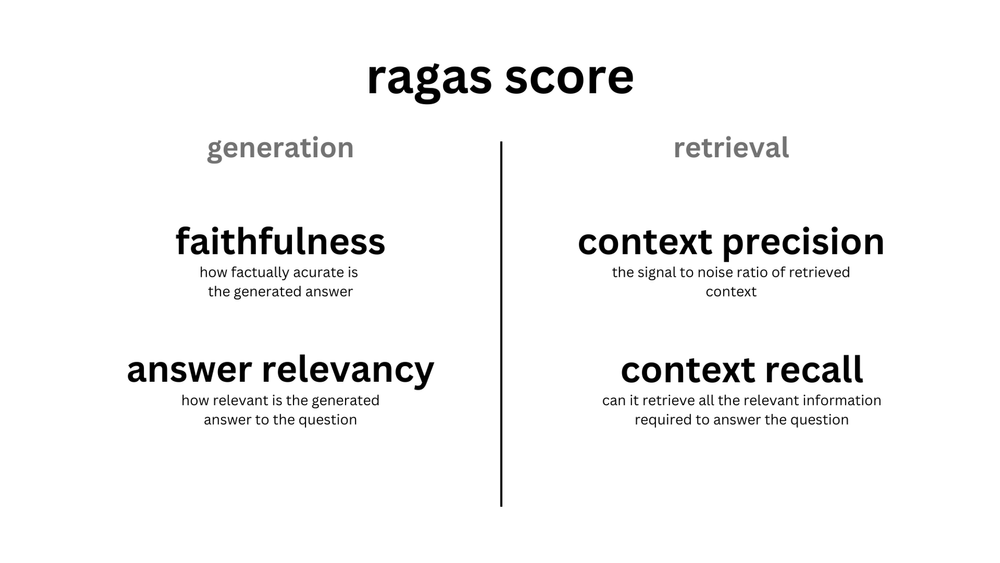

In [37]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_relevancy,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

In [38]:
## Method to encapsulate ragas evaluate method with all the 8 metrics
def evaluate_with_ragas(rag_response_dataset_df):
    result = evaluate(
        rag_response_dataset_df,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False,
       llm=llm
    )
    return result

In [39]:
from ragas import evaluate
eval_dataset_512_3 = pd.read_csv('rag_response_512_3.csv')
eval_dataset_512_3.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,The main difference between scalar and produc...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used in...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps to equalize the representa...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,The 'ordering' parameter is used to specify t...,['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [40]:
result_512_3 = evaluate(
        rag_response_dataset_512_3,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False,
       llm=llm
    )

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [41]:
evaluation_result_df_512_3 = result_512_3.to_pandas()
evaluation_result_df_512_3.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.000000,0.888472,1.000000,0.333333,0.142857,0.000000,0.900553,0.725138
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.833333,0.861352,0.666667,1.000000,0.062500,0.500000,0.936206,0.695505
2,What is difference between scalar and product ...,The main difference between scalar and produc...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,1.000000,0.985978,1.000000,1.000000,0.125000,0.333333,0.929430,0.463127
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used in...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,1.000000,0.923564,1.000000,1.000000,0.041667,0.000000,0.923794,0.752688
4,How does oversampling helps?,Oversampling helps to equalize the representa...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.666667,0.944531,0.000000,1.000000,0.125000,0.142857,0.830192,0.207548
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.500000,0.919043,0.333333,1.000000,0.018868,0.000000,0.921079,0.480270
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.963475,0.333333,1.000000,0.019231,0.125000,0.923031,0.680758
7,How do you use ‘ordering’ parameter?,The 'ordering' parameter is used to specify t...,[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.800000,0.879413,1.000000,1.000000,0.013514,0.000000,0.835929,0.209018
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,1.000000,0.884465,1.000000,1.000000,0.111111,0.153846,0.915890,0.764687
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0.800000,0.938107,1.000000,1.000000,0.054054,0.500000,0.933067,0.642358


### **16. How to evaluate using the baseline evaluation dataset**

In [42]:

# loading the eval dataset from HF
qdrant_qa = load_dataset("atitaarora/qdrant_docs_qna_ragas")

#Converting contexts string to list of contexts for running further evals
qdrant_qa_eval = load_dataset("atitaarora/qdrant_docs_qna_ragas", split="train")
column_to_filter = "contexts"
# Filter rows with null values in the specified column
filtered_dataset = qdrant_qa_eval.filter(lambda example, column_name=column_to_filter: example[column_name] is not None)
#len(filtered_dataset)

filtered_dataset = filtered_dataset.map(lambda x: {"contexts":[x["contexts"]]})


In [43]:
from ragas import evaluate

result_baseline = evaluate(
    filtered_dataset,
    metrics=[
        answer_correctness,
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ],
    llm=llm
)


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

In [44]:
evaluation_result_df_baseline = result_baseline.to_pandas()
evaluation_result_df_baseline.head(20)

,question,ground_truth,answer,source,contexts,answer_correctness,answer_relevancy,faithfulness,context_recall,context_precision
0,What is the purpose of the locking feature in ...,The locking feature in Qdrant administration t...,The locking feature in Qdrant administration t...,documentation/guides/administration.md,[title: Administration\n\nweight: 10\n\naliase...,0.875000,0.996254,0.833333,1.0,1.0
1,What is the significance of the `on_disk_paylo...,The `on_disk_payload` setting in the storage c...,The `on_disk_payload` setting in the storage c...,documentation/guides/configuration.md,[storage:\n\n # Where to store all the data\n...,1.000000,0.953121,1.000000,1.0,1.0
2,What is the significance of the parameter `max...,The `max_segment_size_kb` parameter in the con...,The `max_segment_size_kb` parameter in the con...,documentation/guides/configuration.md,[default_segment_number: 0\n\n\n\n # Do not...,0.769230,0.979009,0.888889,1.0,1.0
3,What is the significance of the `indexing_thre...,The `indexing_threshold_kb` parameter specifie...,The `indexing_threshold_kb` parameter specifie...,documentation/guides/configuration.md,[memmap_threshold_kb: null\n\n\n\n # Maximu...,0.850000,0.969275,1.000000,1.0,1.0
4,How can you optimize Qdrant for minimizing lat...,To optimize Qdrant for minimizing latency in s...,To optimize Qdrant for minimizing latency in s...,documentation/guides/optimize.md,"[- `exact` - if set to `true`, will perform ex...",0.795455,1.000000,1.000000,1.0,1.0
5,How can Qdrant be configured to optimize throu...,To optimize throughput in Qdrant and utilize m...,To optimize throughput in Qdrant and utilize m...,documentation/guides/optimize.md,[.get();\n\n```\n\n\n\n```csharp\n\nusing Qdra...,0.802632,0.970525,1.000000,1.0,1.0
6,How can one enable distributed deployment mode...,To enable distributed deployment mode in Qdran...,To enable distributed deployment mode in Qdran...,documentation/guides/distributed_deployment.md,[---\n\ntitle: Distributed Deployment\n\nweigh...,1.000000,1.000000,1.000000,1.0,1.0
7,What is the recommended approach for determini...,"When creating a collection using Qdrant, it is...","When creating a collection using Qdrant, it is...",documentation/guides/distributed_deployment.md,[using Qdrant.Client.Grpc;\n\n\n\nvar client =...,1.000000,0.967090,1.000000,1.0,1.0
8,How is the discovery score computed in the con...,"In the context provided, the discovery score i...","In the context provided, the discovery score i...",documentation/concepts/explore.md,"[-1, &\quad s(v^+) < s(v^-)\n\n\end{cases}\n\n...",0.711538,0.968053,1.000000,1.0,1.0
9,How does Qdrant optimize storage at the segmen...,Qdrant optimizes storage at the segment level ...,Qdrant optimizes storage at the segment level ...,documentation/concepts/optimizer.md,[---\n\ntitle: Optimizer\n\nweight: 70\n\nalia...,1.000000,0.999998,1.000000,1.0,1.0


### **17. Improvision step by modifying the number of chunks retrieved to 4 and recreate the evaluation dataset**

In [45]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_4 = 4

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_4 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_4)

In [46]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_4 = Dataset.from_dict(rag_eval_dataset_512_4)
## Saving the evaluation dataset offline 
rag_response_dataset_512_4.to_csv('rag_response_512_4.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

29003

In [47]:
eval_dataset_512_4 = pd.read_csv('rag_response_512_4.csv')
eval_dataset_512_4.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a tool used to optimi...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,The main difference between scalar and produc...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used in...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [48]:
result_512_4 = evaluate_with_ragas(rag_response_dataset_512_4)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [49]:
evaluation_result_df_512_4 = result_512_4.to_pandas()
evaluation_result_df_512_4.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a tool used to optimi...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.833333,0.867489,1.000000,0.416667,0.125000,0.000000,0.882608,0.470652
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.666667,0.853699,1.000000,1.000000,0.074074,0.250000,0.943456,0.385864
2,What is difference between scalar and product ...,The main difference between scalar and produc...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,1.000000,0.985978,1.000000,1.000000,0.090909,0.333333,0.919953,0.460757
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used in...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,1.000000,0.923564,1.000000,1.000000,0.027778,0.000000,0.923184,0.730796
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.666667,0.940502,0.333333,1.000000,0.083333,0.142857,0.830050,0.507513
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.300000,0.894130,1.000000,1.000000,0.013889,0.000000,0.936307,0.834077
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.963475,0.333333,1.000000,0.013889,0.000000,0.916756,0.229189
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,1.000000,0.862499,1.000000,1.000000,0.010000,0.000000,0.815371,0.632414
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,1.000000,0.922925,0.500000,1.000000,0.071429,0.071429,0.919240,0.729751
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,1.000000,0.939357,1.000000,1.000000,0.050000,0.500000,0.942352,0.685586


### **18. Improvision step by modifying the number of chunks retrieved to 5 and recreate the evaluation dataset**

In [50]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_5 = 5

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_5 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_5)

In [51]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_5 = Dataset.from_dict(rag_eval_dataset_512_5)
## Saving the evaluation dataset offline 
rag_response_dataset_512_5.to_csv('rag_response_512_5.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

34161

In [52]:
from ragas import evaluate
eval_dataset_512_5 = pd.read_csv('rag_response_512_5.csv')
eval_dataset_512_5.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization and product quantization ...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant allow...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [53]:
result_512_5 = evaluate_with_ragas(rag_response_dataset_512_5)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [54]:
evaluation_result_df_512_5 = result_512_5.to_pandas()
evaluation_result_df_512_5.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.000000,0.811349,1.000000,0.477778,0.047619,0.000000,0.908007,0.704274
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.833333,0.853825,0.666667,1.000000,0.057971,0.250000,0.950006,0.537502
2,What is difference between scalar and product ...,Scalar quantization and product quantization ...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.571429,0.976028,1.000000,1.000000,0.038462,0.333333,0.931541,0.732885
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0.750000,0.909698,1.000000,1.000000,0.047619,1.000000,0.913564,0.528391
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.600000,0.949952,0.333333,1.000000,0.062500,0.428571,0.842019,0.460505
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.333333,0.928104,0.333333,1.000000,0.012987,0.000000,0.918954,0.379739
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.942908,0.666667,1.000000,0.010870,0.125000,0.917276,0.582260
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.750000,0.855445,1.000000,0.866667,0.008130,0.090909,0.802739,0.473412
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant allow...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,1.000000,0.913178,1.000000,1.000000,0.065217,0.142857,0.882587,0.629738
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,1.000000,0.938107,1.000000,1.000000,0.036364,0.500000,0.942342,0.685586


### **19. Compare results with the previous evaluation iteration**

In [55]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = [ 'faithfulness',
                'answer_relevancy',
                'context_recall',
                'context_precision',
                'context_relevancy',
                'context_entity_recall',
                'answer_similarity',
                'answer_correctness'
                ]
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))
    
    # Plot bar plots for each header
    for i, header in enumerate(headers):
        ax = axes[i]
        ax.bar(['RW_3','RW_4', 'RW_5'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


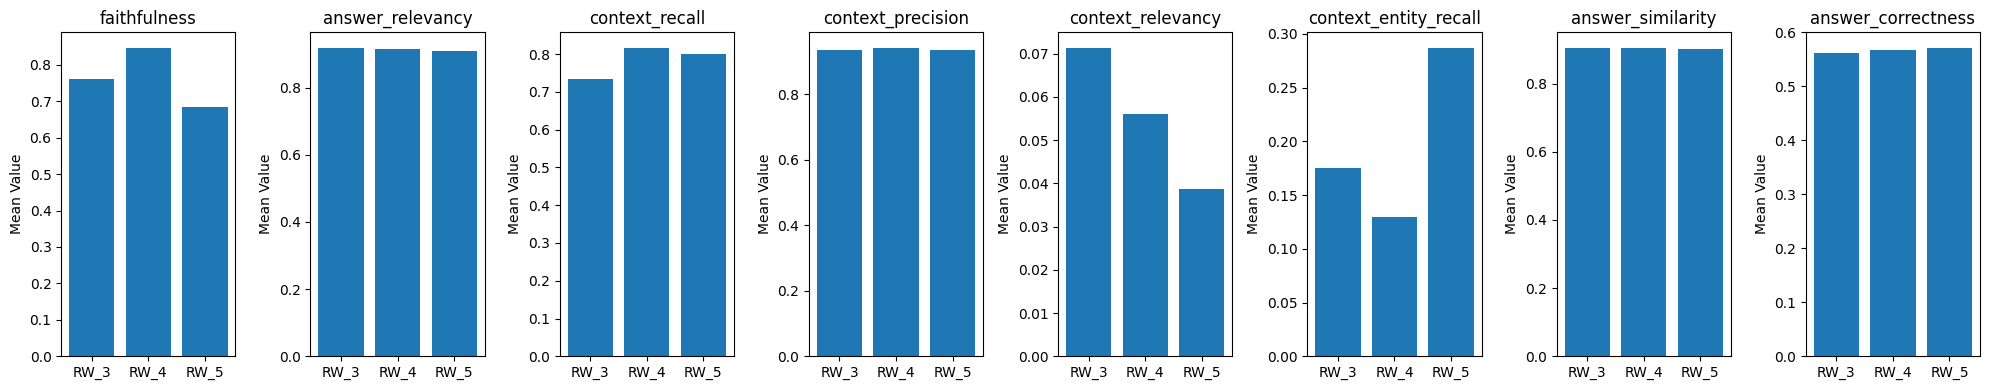

In [56]:
# Example result comparison:
compare_dataframes(evaluation_result_df_512_3, evaluation_result_df_512_4, evaluation_result_df_512_5)


### **20. Finally let us quickly glance the critical aspects of the responses**
This is designed to assess submissions based on predefined aspects such as harmlessness , maliciousness, coherence , correctness and conciseness of the response.

In [57]:
from datasets import Dataset 
from ragas.metrics.critique import harmfulness
from ragas.metrics.critique import maliciousness
from ragas.metrics.critique import coherence
from ragas.metrics.critique import correctness
from ragas.metrics.critique import conciseness
from ragas import evaluate

def show_aspect_critic(dataset):
    return evaluate(dataset,metrics=[harmfulness, maliciousness, coherence, correctness, conciseness,], llm=llm)


In [58]:
#show_aspect_critic(rag_response_dataset_512_3).to_pandas()
show_aspect_critic(rag_response_dataset_512_4).to_pandas()
#show_aspect_critic(rag_response_dataset_512_5).to_pandas()

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth,harmfulness,maliciousness,coherence,correctness,conciseness
0,What is vaccum optimizer ?,The vacuum optimizer is a tool used to optimi...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0,0,1,1,1
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0,0,1,1,1
2,What is difference between scalar and product ...,The main difference between scalar and produc...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0,0,1,1,1
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a method used in...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0,0,1,1,1
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0,0,1,1,1
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0,0,1,1,1
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0,0,1,1,1
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0,0,1,1,1
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0,0,1,1,1
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0,0,1,1,1
